In [1]:
import os
import json
import sys
sys.path.append("../")

from tqdm import tqdm
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
data_dir = "../../data/google_patents/us-25000"
data_ratio = {"train": 0.8, "dev": 0.1, "test": 0.1}
random_state = np.random.RandomState(1)

save_data_path = os.path.join(data_dir, "data.ndjson")
save_label_path = os.path.join(data_dir, "doc_label_encoder.json")

In [3]:
doc_files = utils.get_file_name_in_dir(os.path.join(data_dir, "doc"), "json")
print("Number of document files:", len(doc_files))

Number of document files: 10


**Data format:**

A .json file contains multiple patents on different lines.

Format of each patent:

```json
{
    "patent_id": str,
    "title": [{"text": str, "language": str, "truncated": bool}],
    "description": [{"text": str, "language": str, "truncated": bool}],
    "claims": [{"text": str, "language": str, "truncated": bool}],
    "classifications": [{"code": str, "inventive": bool, "first": bool, "tree": List[str]}, ...]
}
```

In [4]:
sample_doc_file = doc_files[0]
with open(sample_doc_file, "r") as f:
    for line in f:
        sample_doc = json.loads(line)
        break
sample_doc["classifications"]

[{'code': 'A46B11/0006', 'inventive': True, 'first': True, 'tree': []},
 {'code': 'A46B9/023', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A45D24/28', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B5/0095', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A45D24/22', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B11/002', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B2200/104', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B9/023', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B2200/104', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A45D24/22', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B11/0006', 'inventive': True, 'first': True, 'tree': []},
 {'code': 'A46B5/0095', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B11/002', 'inventive': False, 'first': False, 'tree': []}]

In [5]:
def get_id(doc):
    return doc["patent_id"]

def get_content(doc):
    return "\n".join(c["text"].strip() for c in doc["claims"])

def get_title(doc):
    return "\n".join(c["text"] for c in doc["title"])

def get_label(doc):
    return list(set(x["code"][:4] for x in doc["classifications"]))

def get_sample(doc):
    return {"id": get_id(doc), "title": get_title(doc), "content": get_content(doc), "labels": get_label(doc)}

In [6]:
samples = []
for fname in doc_files:
    with open(fname, "r") as f:
        for line in f:
            doc = json.loads(line)
            if get_label(doc) and get_content(doc):
                samples.append(get_sample(doc))
        
doc_ids = random_state.permutation([x["id"] for x in samples if x["labels"]])
print("Number of valid documents:", len(doc_ids))

Number of valid documents: 17952


In [7]:
freq = {}
for x in samples:
    for label in x["labels"]:
        freq[label] = freq.get(label, 0) + 1

labels = set(k for k, v in freq.items() if v >= 30)
label_ids = {x : i for i, x in enumerate(sorted(labels))}
utils.dump_json(label_ids, save_label_path)
print("Number of labels:", len(labels))

Number of labels: 233


In [8]:
new_samples = []
for sample in tqdm(samples):
    sample["labels"] = [e for e in sample["labels"] if e in labels]
    if len(sample["labels"]) != 0:
        new_samples.append(sample)

samples = new_samples

100%|██████████| 17952/17952 [00:00<00:00, 487098.32it/s]


In [9]:
from skmultilearn.model_selection import iterative_train_test_split
X_raw = np.array([[x] for x in samples])
y_raw = np.matrix([utils.get_onehot(x["labels"], label_ids) for x in samples])
X, y = {}, {}
y_raw.shape

(17009, 233)

In [10]:
X["train"], y["train"], X["test"], y["test"] = iterative_train_test_split(X_raw, y_raw, test_size=0.1)

In [11]:
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["test"] == 1)[1]).tolist()))

set()

In [12]:
X["train"], y["train"], X["dev"], y["dev"] = iterative_train_test_split(X["train"], y["train"], test_size=len(y["test"]) / len(y["train"]))

In [13]:
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["dev"] == 1)[1]).tolist()))

set()

In [14]:
samples = []
for data_type in ("train", "dev", "test"):
    for sample in X[data_type]:
        sample = sample[0]
        sample["is_train"] = sample["is_dev"] = sample["is_test"] = False
        sample[f"is_{data_type}"] = True
        samples.append(sample)

In [15]:
with open(save_data_path, "w") as f:
    for sample in tqdm(samples):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")

100%|██████████| 17009/17009 [00:01<00:00, 13847.74it/s]


In [16]:
import pandas as pd
df = pd.DataFrame(samples)
df

,id,title,content,labels,is_train,is_dev,is_test
0,US-10194740-B2,Fluid dispensing brush assembly,I claim: \n \n 1. A fluid dispensing...,[A45D],True,False,False
1,US-10193177-B2,Fuel cell system and operating method therefor,The invention claimed is: \n \n 1. A...,"[H01M, Y02E, Y02T]",True,False,False
2,US-10115795-B2,Semiconductor device and method of manufacturi...,What is claimed is: \n \n 1. A semic...,[H01L],True,False,False
3,US-10045307-B2,Communication system for setting an uplink tar...,The invention claimed is: \n \n 1. A...,[H04W],True,False,False
4,US-10103729-B2,Auxiliary commutated silicon-controlled rectif...,What is claimed is: \n \n 1. A devic...,"[H03K, H02M]",True,False,False
...,...,...,...,...,...,...,...
17004,US-2013022248-A1,Biometrics based on locally consistent features,1 . A method of performing a biometric functio...,"[G07C, A61B, G06K]",False,False,True
17005,US-2012172256-A1,Cantilevered probes having piezoelectric layer...,1 . A chemical sensor system comprising:\n a f...,[B82Y],False,False,True
17006,US-9815821-B2,Condensed-cyclic compound and organic light em...,What is claimed is: \n \n 1. A conde...,"[C07D, H01L]",False,False,True
17007,US-9823534-B2,Electrochromic single and two-core viologens a...,The invention claimed is: \n \n 1. A...,"[G02F, C07D, C09K]",False,False,True


In [17]:
sum(df["is_train"]), sum(df["is_dev"]), sum(df["is_test"])

(13502, 1781, 1726)

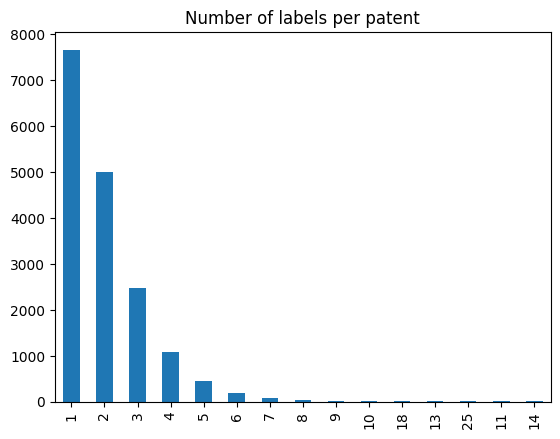

In [18]:
ax = df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");
plt.show()

**Check**

In [19]:
df["content"].apply(lambda x : len(x.split())).mean()

1009.689634899171

In [20]:
len(label_ids)

233

In [21]:
df[df["content"].apply(lambda x : len(x)) == 0]

,id,title,content,labels,is_train,is_dev,is_test


In [22]:
res = set()
for x in df[df["is_train"]]["labels"].values:
    res.update(x)
len(res)

233

In [23]:
res = set()
for x in df[df["is_dev"]]["labels"].values:
    res.update(x)
len(res)

233

In [24]:
res = set()
for x in df[df["is_test"]]["labels"].values:
    res.update(x)
len(res)

233